In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#import packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

import copy

In [5]:
#Select a device
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

In [6]:
#load the images

imsize = 512 if torch.cuda.is_available() else 128

loader = transforms.Compose([
     transforms.Resize(imsize), # scale imported image
     transforms.ToTensor() # transform it into a torch tensor
])

def image_loader(image_name):
  image = Image.open(image_name)
  # fake batch dimension required to fit network's input dimensions
  image = loader(image).unsqueeze(0)
  return image.to(device, torch.float)

style_img = image_loader("/content/drive/MyDrive/Colab Notebooks/images/picasso.jpg")
content_img =image_loader("/content/drive/MyDrive/Colab Notebooks/images/dancing.jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

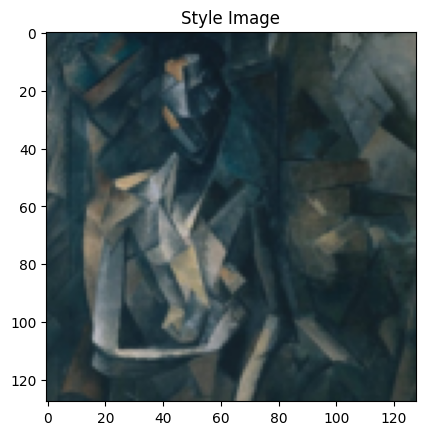

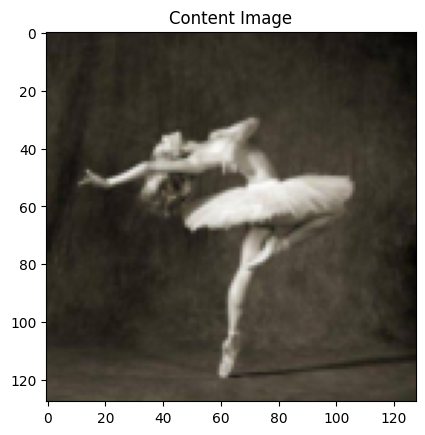

In [7]:
unloader = transforms.ToPILImage() # reconvert into PIL image
#Enable interactive mode, pictures will be automatically shown
plt.ion()

def imshow(tensor, title=None):
  image = tensor.cpu().clone() # we clone the tensor to not do changes on it
  image = image.squeeze(0)     # remove the fake batch dimension
  image = unloader(image)
  plt.imshow(image)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)             # pause a bit so that plots are updated

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')



In [8]:
# content loss
# designed to be used as a layer in a neural network

class ContentLoss(nn.Module):
  def __init__(self, target,):
    super(ContentLoss, self).__init__()
    # The .detach() method creates a new tensor
    # that shares the data with the original target tensor
    # but is detached from the computational graph.
    # Detaching it ensures that when we calculate the loss
    # the gradients are not propagated back to the original target tensor, preventing unintended changes to it
    self.target = target.detach()

  def forward(self, input):
    self.loss = F.mse_loss(input, self.target)
    # to calculate and store the content loss (self.loss), not to modify the input.
    return input

In [1]:
# style loss
def gram_matrix(input):
  a,b,c,d = input.size()
  # reshapes the input tensor into a matrix
  features =  input.view(a*b,c*d)
  # calculates the Gram matrix (G) by performing a matrix multiplication of the features matrix with its transpose
  # The Gram matrix essentially captures the correlations between different feature channels in the input
  G = torch.mm(features,features.t())
  # normalizes the Gram matrix by dividing it by the total number of elements in the original input tensor
  return G.div(a*b*c*d)

In [4]:
class Styleloss(nn.Module):
  def __init__(self, target_feature):
    super(Styleloss, self).__init__()
    self.target = gram_matrix(target_feature).detach()

  def forward(self, input):
    G = gram_matrix(input)
    self.loss = F.mse_loss(G, self.target)
    return input